In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
# Connecting to database
database = "database.sqlite"
con = sqlite3.connect(database)
pd.set_option('display.max_columns', None)

In [3]:
#Get important tables from db
matches_df = pd.read_sql("""SELECT * from MATCH""", con)
teams_df = pd.read_sql("""SELECT * from TEAM""", con)
player_attributes_df = pd.read_sql("""SELECT * from PLAYER_ATTRIBUTES""", con)
team_attributes_df = pd.read_sql("""SELECT * from TEAM_ATTRIBUTES""", con)

In [5]:
#Get players' attributes (overall)

#Get players info
home_players = ["home_player_" + str(x) for x in range(1, 12)]
away_players = ["away_player_" + str(x) for x in range(1, 12)]

matches_kept_columns = ["id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]
matches_kept_columns = matches_kept_columns + home_players
matches_kept_columns = matches_kept_columns + away_players

matches_df = matches_df[matches_kept_columns]

#Get overall ratings for all players from player_attributes table
for player in home_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
for player in away_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
 

matches_df = matches_df.rename(columns={"overall_rating": "overall_rating_home_player_1"})

matches_df['overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].sum(axis=1)
matches_df['overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].sum(axis=1)
matches_df['overall_rating_difference'] = matches_df['overall_rating_home'] - matches_df['overall_rating_away']

matches_df['mean_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].mean(axis=1)
matches_df['mean_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].mean(axis=1)


#Remove all players column because we just need the "global" ones
for c in matches_df.columns:
    if '_player_' in c:
        matches_df = matches_df.drop(c, axis=1)

In [6]:
matches_aux = pd.read_sql("""SELECT * FROM MATCH""" ,con)

#Select all bet columns (removed PSA, PSH, PSD because they are almost all NaN)
bet_columns = ["B365H", "B365A", "B365D", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA", "LBH", "LBD", "LBA", "WHH", "WHD", "WHA", "SJH", "SJD", "SJA", "VCH", "VCD", "VCA", "GBH", "GBD", "GBA", "BSH", "BSD", "BSA"]

#Get specific columns for bets on home and draw
bet_columns_home = ["B365H", "BWH","IWH", "LBH", "WHH", "SJH", "VCH", "GBH","BSH"]
bet_columns_draw = ["B365D", "BWD","IWD", "LBD", "WHD", "SJD", "VCD", "GBD","BSD"]

#Calculate mean values for bets on home team and draw. Add these values to match table
matches_df['mean_bets_home'] = matches_aux[bet_columns_home].mean(axis=1)
matches_df['mean_bets_draw'] = matches_aux[bet_columns_draw].mean(axis=1)

In [7]:
#Replace NaN values (on bets) with mean values 
matches_df.fillna(matches_df.mean(), inplace=True)
matches_df.isnull().sum()

id                           0
league_id                    0
date                         0
home_team_api_id             0
away_team_api_id             0
home_team_goal               0
away_team_goal               0
overall_rating_home          0
overall_rating_away          0
overall_rating_difference    0
mean_overall_rating_home     0
mean_overall_rating_away     0
mean_bets_home               0
mean_bets_draw               0
dtype: int64

In [8]:
#Get goal difference
matches_df['goal_diff'] = matches_df['home_team_goal'] - matches_df['away_team_goal']

matches_df['Game Result'] = 'Defeat'
matches_df['Game Result'] = np.where(matches_df['goal_diff'] == 0, 'Draw', matches_df['Game Result'])
matches_df['Game Result'] = np.where(matches_df['goal_diff'] > 0, 'Win', matches_df['Game Result'])


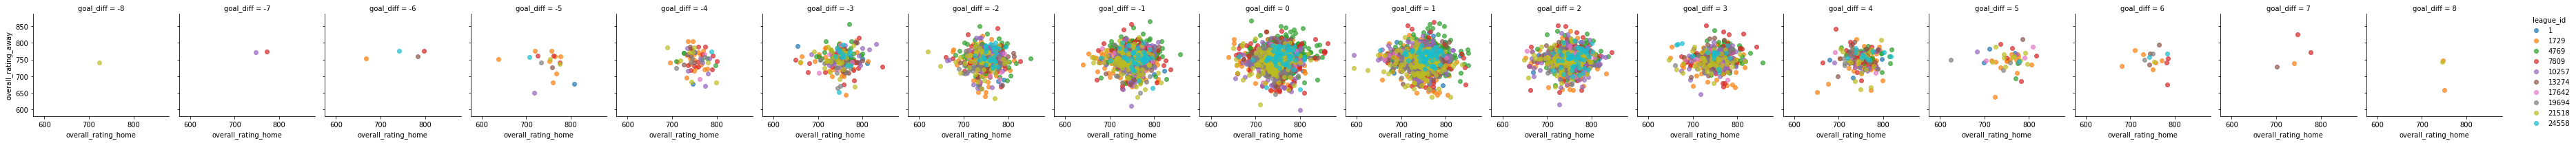

In [9]:
h = sns.FacetGrid(matches_df, col="goal_diff", hue="league_id")
h.map(plt.scatter, "overall_rating_home", "overall_rating_away", alpha=.7)
h.add_legend();

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


''

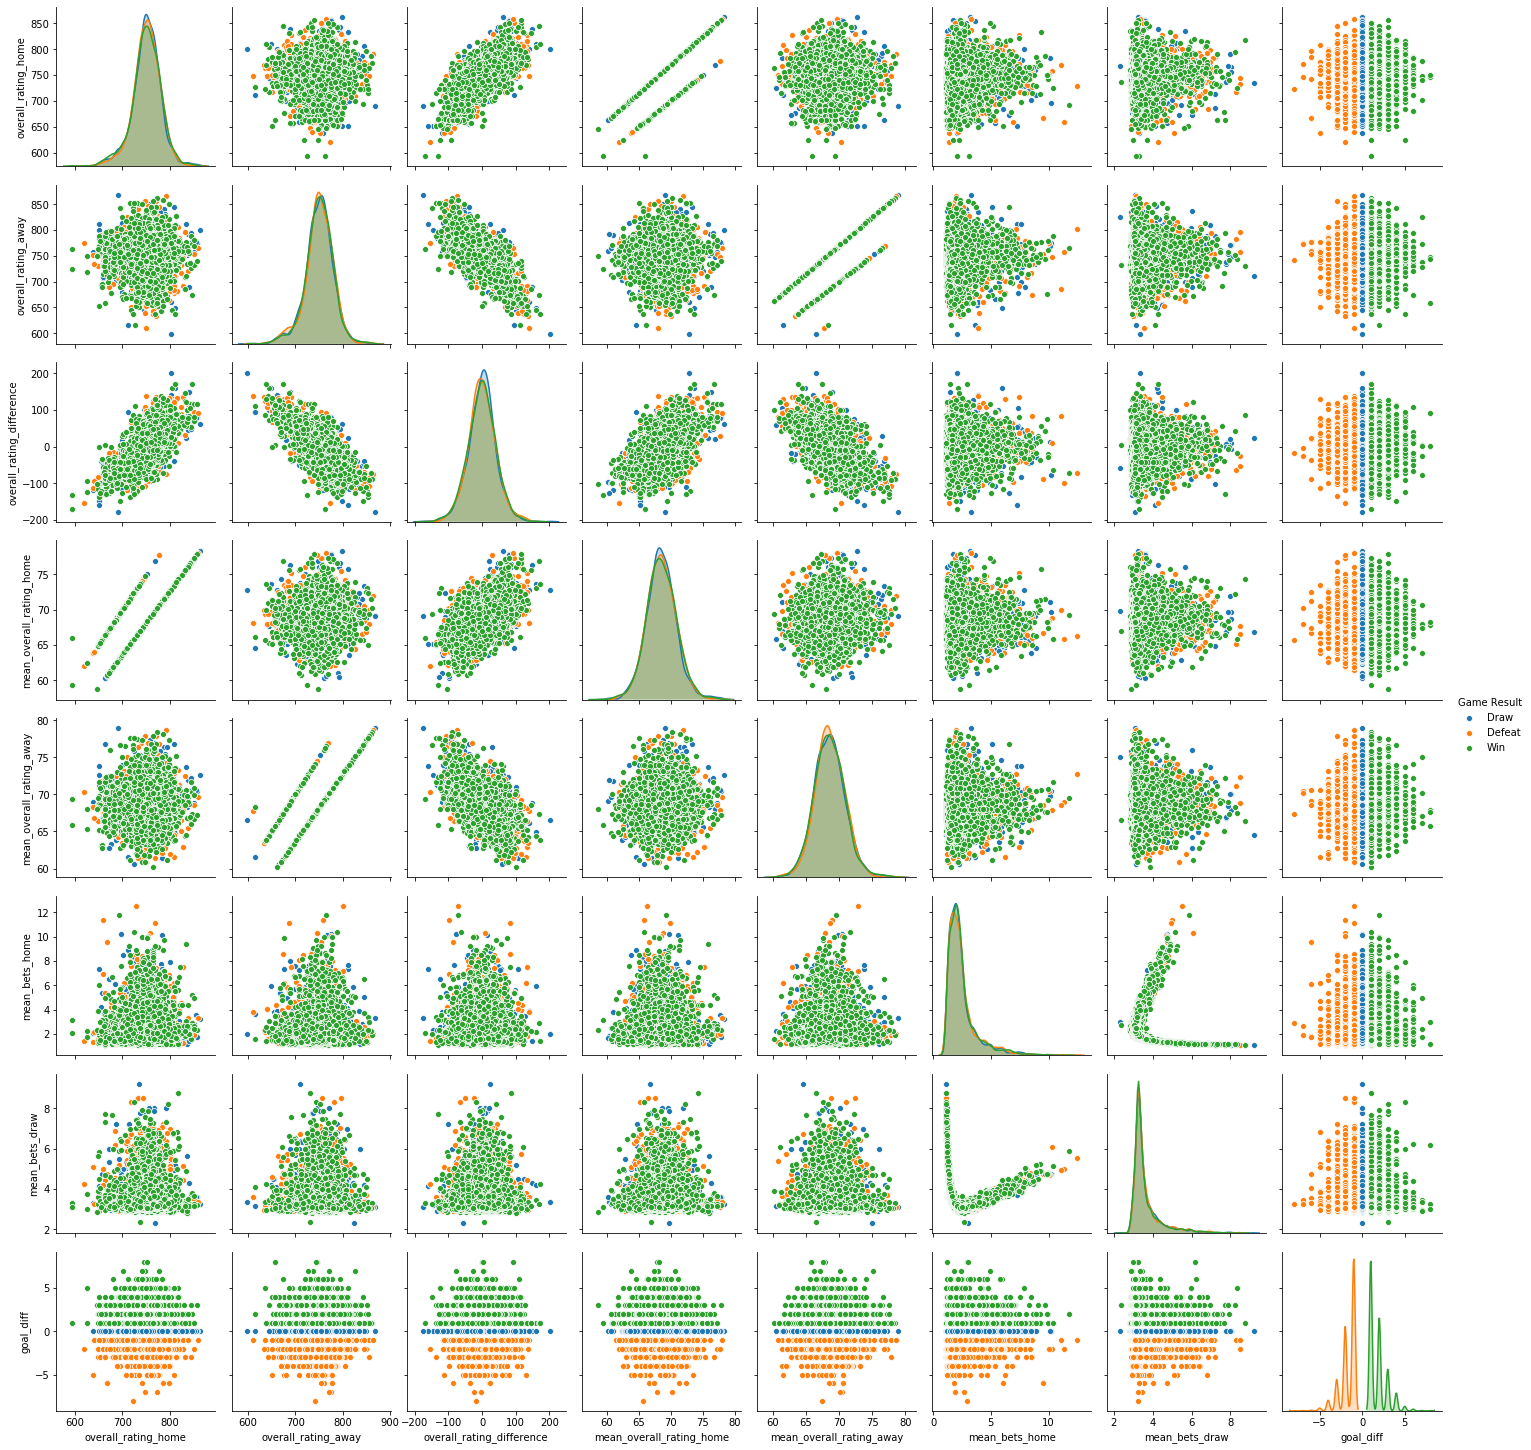

In [10]:
mini_match = matches_df[matches_df.columns[7:16]]
mini_match
sns.pairplot(mini_match, hue='Game Result')
;

In [11]:
matches_df = matches_df.drop(['id', 'date', 'home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','overall_rating_difference', 'goal_diff'], axis=1)
y = matches_df['Game Result']
X = matches_df.drop('Game Result', axis=1)
X

,league_id,overall_rating_home,overall_rating_away,mean_overall_rating_home,mean_overall_rating_away,mean_bets_home,mean_bets_draw
0,7809,746.0,783.0,67.818182,71.181818,1.765556,3.322222
1,7809,772.0,790.0,70.181818,71.818182,1.898889,3.250000
2,7809,780.0,719.0,70.909091,71.900000,2.462222,3.233333
3,7809,688.0,717.0,68.800000,71.700000,1.438889,3.805556
4,7809,733.0,770.0,66.636364,70.000000,4.494444,3.422222
...,...,...,...,...,...,...,...
6537,19694,772.0,780.0,70.181818,70.909091,2.044444,3.144444
6538,19694,755.0,720.0,68.636364,65.454545,2.284444,3.097778
6539,17642,752.0,779.0,68.363636,70.818182,2.282222,3.066667
6540,13274,682.0,755.0,68.200000,68.636364,2.515556,3.100000


In [12]:
#Train set selection
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [13]:
#Normalization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-0.65484791,  0.47962999,  0.1839004 , ...,  0.05329323,
        -0.80409666,  0.79908931],
       [ 0.4902639 ,  0.27334382, -1.50087832, ..., -1.88681991,
         1.83238381,  0.19300915],
       [ 0.08405551, -0.07046647,  0.04636744, ..., -0.10508335,
        -0.3775066 , -0.11298022],
       ...,
       [ 0.08405551, -0.24237161, -0.09116552, ..., -0.26345993,
        -0.39374951, -0.72127234],
       [-0.24554281,  0.37648691,  1.14663109, ...,  1.16192932,
         0.51670824, -0.44846254],
       [-0.24554281, -0.75808704,  1.49046348, ...,  1.55787078,
         0.55004895, -0.55168787]])